Otro uso de los AEs es el denoising, donde se intenta reparar imagenes corruptas. Un dAE es basicamente un AE donde la entrada es una imagen con ruido encima y el output es la imagen original (o una mas parecida a esta)


Primero se generara un conjunto de imagenes sinteticamente corruptas a partir de MNIST y un filtro de ruido con distribucion Ber(p), donde p=0.1 es el ruido.

In [1]:
from keras.datasets import mnist
from numpy.random import binomial
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import load_model
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


NVAL=5000
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_val=x_train[:NVAL]
x_train=x_train[NVAL:]

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Y_val=Y_train[:NVAL]
Y_train=Y_train[NVAL:]

noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask



Using TensorFlow backend.


Se construye un dAE de estructura 784x32

In [27]:
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0,momentum=0.9, nesterov=True), loss='binary_crossentropy')
hist=autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
validation_data=(noisy_x_val, x_val))
autoencoder.save('AE/autoencoder_denoise__bern1.h5')
encoder.save('AE/encoder_denoise_bern1.h5')
decoder.save('AE/decoder_denoise_bern1.h5')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s - loss: 0.2411 - val_loss: 0.2098
Epoch 2/50
55000/55000 [==============================] - 3s - loss: 0.2032 - val_loss: 0.1985
Epoch 3/50
55000/55000 [==============================] - 3s - loss: 0.1959 - val_loss: 0.1938
Epoch 4/50
55000/55000 [==============================] - 3s - loss: 0.1922 - val_loss: 0.1910
Epoch 5/50
55000/55000 [==============================] - 4s - loss: 0.1898 - val_loss: 0.1894
Epoch 6/50
55000/55000 [==============================] - 3s - loss: 0.1883 - val_loss: 0.1880
Epoch 7/50
55000/55000 [==============================] - 3s - loss: 0.1872 - val_loss: 0.1872
Epoch 8/50
55000/55000 [==============================] - 3s - loss: 0.1863 - val_loss: 0.1865
Epoch 9/50
55000/55000 [==============================] - 3s - loss: 0.1856 - val_loss: 0.1858
Epoch 10/50
55000/55000 [==============================] - 3s - loss: 0.1850 - val_loss: 0.1854


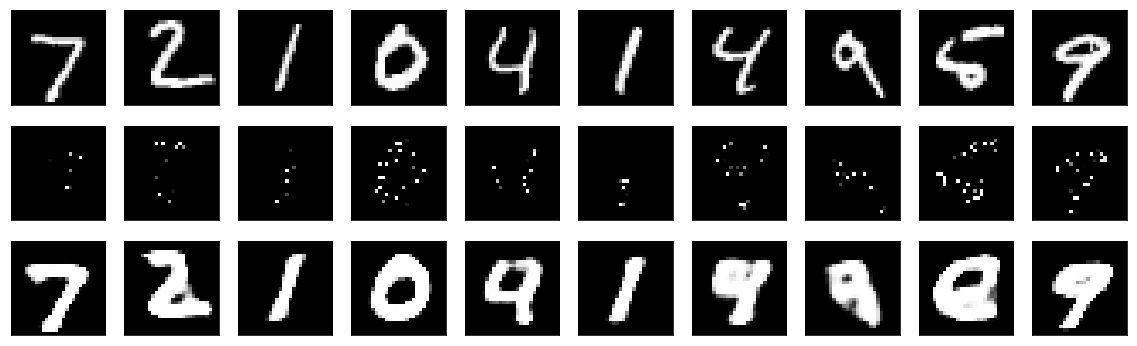

In [28]:
autoencoder=load_model('AE/autoencoder_denoise_bern1.h5')

decoder=load_model('AE/decoder_denoise_bern1.h5')
encoder=load_model('AE/encoder_denoise_bern1.h5')

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
	ax = plt.subplot(3, n, i + 1)
	plt.imshow(x_test[i].reshape(28, 28))
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

	ax = plt.subplot(3, n, i + 1+n )
	plt.imshow(noisy_x_test[i].reshape(28, 28))
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
    
    
	ax = plt.subplot(3, n, i + 1 + n*2)
	plt.imshow(decoded_imgs[i].reshape(28, 28))
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
    

    
plt.show()

Los resultados son relativamente satisfactorios, con un error de 0.1804 se pueden identificar en  algunos casos el digito original, por otro lado, las imagenes corruptas no se parecen a la imagen original, esto debido al bajo valor de p, 0.1 esto significa que solo el 10% de la imagen original se mantiene en la corrupta. Para valores mayores de p se esperan resultados mejores 

In [29]:
loss=[]
for p in range(1,10) :    #los casos p=0 y p=1 se descartan ya que son triviales
    noise_level = p/10.0  #para 0 son solo imagenes negras y para 1 son las originales
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask   
    
    
    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0,momentum=0.9, nesterov=True), loss='binary_crossentropy')
    hist=autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
    validation_data=(noisy_x_val, x_val))
    autoencoder.save('AE/autoencoder_denoise_bern'+str(p)+'.h5')
    encoder.save('AE/encoder_denoise_bern'+str(p)+'.h5')
    decoder.save('AE/decoder_denoise_bern'+str(p)+'.h5')
    loss.append(hist.history['val_loss'][-1])
print(loss)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s - loss: 0.2409 - val_loss: 0.2091
Epoch 2/50
55000/55000 [==============================] - 3s - loss: 0.2026 - val_loss: 0.1973
Epoch 3/50
55000/55000 [==============================] - 3s - loss: 0.1953 - val_loss: 0.1927
Epoch 4/50
55000/55000 [==============================] - 3s - loss: 0.1918 - val_loss: 0.1902
Epoch 5/50
55000/55000 [==============================] - 3s - loss: 0.1897 - val_loss: 0.1889
Epoch 6/50
55000/55000 [==============================] - 3s - loss: 0.1883 - val_loss: 0.1875
Epoch 7/50
55000/55000 [==============================] - 3s - loss: 0.1873 - val_loss: 0.1867
Epoch 8/50
55000/55000 [==============================] - 3s - loss: 0.1865 - val_loss: 0.1861
Epoch 9/50
55000/55000 [==============================] - 3s - loss: 0.1858 - val_loss: 0.1855
Epoch 10/50
55000/55000 [==============================] - 3s - loss: 0.1853 - val_loss: 0.1850


55000/55000 [==============================] - 3s - loss: 0.1540 - val_loss: 0.1542
Epoch 36/50
55000/55000 [==============================] - 3s - loss: 0.1540 - val_loss: 0.1541
Epoch 37/50
55000/55000 [==============================] - 3s - loss: 0.1539 - val_loss: 0.1542
Epoch 38/50
55000/55000 [==============================] - 4s - loss: 0.1538 - val_loss: 0.1540
Epoch 39/50
55000/55000 [==============================] - 3s - loss: 0.1537 - val_loss: 0.1539
Epoch 40/50
55000/55000 [==============================] - 3s - loss: 0.1536 - val_loss: 0.1538
Epoch 41/50
55000/55000 [==============================] - 3s - loss: 0.1536 - val_loss: 0.1538
Epoch 42/50
55000/55000 [==============================] - 3s - loss: 0.1535 - val_loss: 0.1538
Epoch 43/50
55000/55000 [==============================] - 4s - loss: 0.1535 - val_loss: 0.1537
Epoch 44/50
55000/55000 [==============================] - 3s - loss: 0.1534 - val_loss: 0.1537
Epoch 45/50
55000/55000 [===========================

55000/55000 [==============================] - 5s - loss: 0.1334 - val_loss: 0.1329
Epoch 20/50
55000/55000 [==============================] - 5s - loss: 0.1332 - val_loss: 0.1326
Epoch 21/50
55000/55000 [==============================] - 4s - loss: 0.1329 - val_loss: 0.1325
Epoch 22/50
55000/55000 [==============================] - 4s - loss: 0.1327 - val_loss: 0.1322
Epoch 23/50
55000/55000 [==============================] - 4s - loss: 0.1325 - val_loss: 0.1322
Epoch 24/50
55000/55000 [==============================] - 4s - loss: 0.1323 - val_loss: 0.1321
Epoch 25/50
55000/55000 [==============================] - 4s - loss: 0.1322 - val_loss: 0.1319
Epoch 26/50
55000/55000 [==============================] - 4s - loss: 0.1320 - val_loss: 0.1317
Epoch 27/50
55000/55000 [==============================] - 4s - loss: 0.1319 - val_loss: 0.1314
Epoch 28/50
55000/55000 [==============================] - 5s - loss: 0.1317 - val_loss: 0.1318
Epoch 29/50
55000/55000 [===========================

55000/55000 [==============================] - 4s - loss: 0.1232 - val_loss: 0.1227
Epoch 4/50
55000/55000 [==============================] - 4s - loss: 0.1224 - val_loss: 0.1221
Epoch 5/50
55000/55000 [==============================] - 4s - loss: 0.1219 - val_loss: 0.1217
Epoch 6/50
55000/55000 [==============================] - 4s - loss: 0.1215 - val_loss: 0.1213
Epoch 7/50
55000/55000 [==============================] - 5s - loss: 0.1212 - val_loss: 0.1209
Epoch 8/50
55000/55000 [==============================] - 5s - loss: 0.1210 - val_loss: 0.1208
Epoch 9/50
55000/55000 [==============================] - 5s - loss: 0.1207 - val_loss: 0.1209
Epoch 10/50
55000/55000 [==============================] - 4s - loss: 0.1205 - val_loss: 0.1204
Epoch 11/50
55000/55000 [==============================] - 5s - loss: 0.1204 - val_loss: 0.1203
Epoch 12/50
55000/55000 [==============================] - 4s - loss: 0.1202 - val_loss: 0.1202
Epoch 13/50
55000/55000 [==============================] -

55000/55000 [==============================] - 5s - loss: 0.1120 - val_loss: 0.1118
Epoch 39/50
55000/55000 [==============================] - 5s - loss: 0.1119 - val_loss: 0.1117
Epoch 40/50
55000/55000 [==============================] - 5s - loss: 0.1119 - val_loss: 0.1117
Epoch 41/50
55000/55000 [==============================] - 5s - loss: 0.1118 - val_loss: 0.1121
Epoch 42/50
55000/55000 [==============================] - 5s - loss: 0.1118 - val_loss: 0.1117
Epoch 43/50
55000/55000 [==============================] - 5s - loss: 0.1117 - val_loss: 0.1117
Epoch 44/50
55000/55000 [==============================] - 5s - loss: 0.1117 - val_loss: 0.1117
Epoch 45/50
55000/55000 [==============================] - 4s - loss: 0.1117 - val_loss: 0.1117
Epoch 46/50
55000/55000 [==============================] - 4s - loss: 0.1116 - val_loss: 0.1117
Epoch 47/50
55000/55000 [==============================] - 4s - loss: 0.1116 - val_loss: 0.1115
Epoch 48/50
55000/55000 [===========================

55000/55000 [==============================] - 5s - loss: 0.1006 - val_loss: 0.1004
Epoch 23/50
55000/55000 [==============================] - 5s - loss: 0.1005 - val_loss: 0.1002
Epoch 24/50
55000/55000 [==============================] - 5s - loss: 0.1005 - val_loss: 0.1003
Epoch 25/50
55000/55000 [==============================] - 5s - loss: 0.1005 - val_loss: 0.1004
Epoch 26/50
55000/55000 [==============================] - 5s - loss: 0.1004 - val_loss: 0.1003
Epoch 27/50
55000/55000 [==============================] - 5s - loss: 0.1004 - val_loss: 0.1003
Epoch 28/50
55000/55000 [==============================] - 5s - loss: 0.1004 - val_loss: 0.1003
Epoch 29/50
55000/55000 [==============================] - 5s - loss: 0.1004 - val_loss: 0.1004
Epoch 30/50
55000/55000 [==============================] - 5s - loss: 0.1003 - val_loss: 0.1002
Epoch 31/50
55000/55000 [==============================] - 5s - loss: 0.1003 - val_loss: 0.0999
Epoch 32/50
55000/55000 [===========================

Resumen de los errores obtenidos:

| p | 0.1   |0.2 |0.3|0.4|0.5|0.6|0.7|0.8|0.9|
|------|------|-|------|--|-|-|-|-|-|
| Error| 0.1798| 0.1532 |0.1396| 0.1301 |0.1220 |0.1170| 0.1116| 0.1061| 0.0998|

Se observa que el error se reduce a medida que p sube, lo que se esperaba, a continuacion se muestran los denoising resultantes del AC.

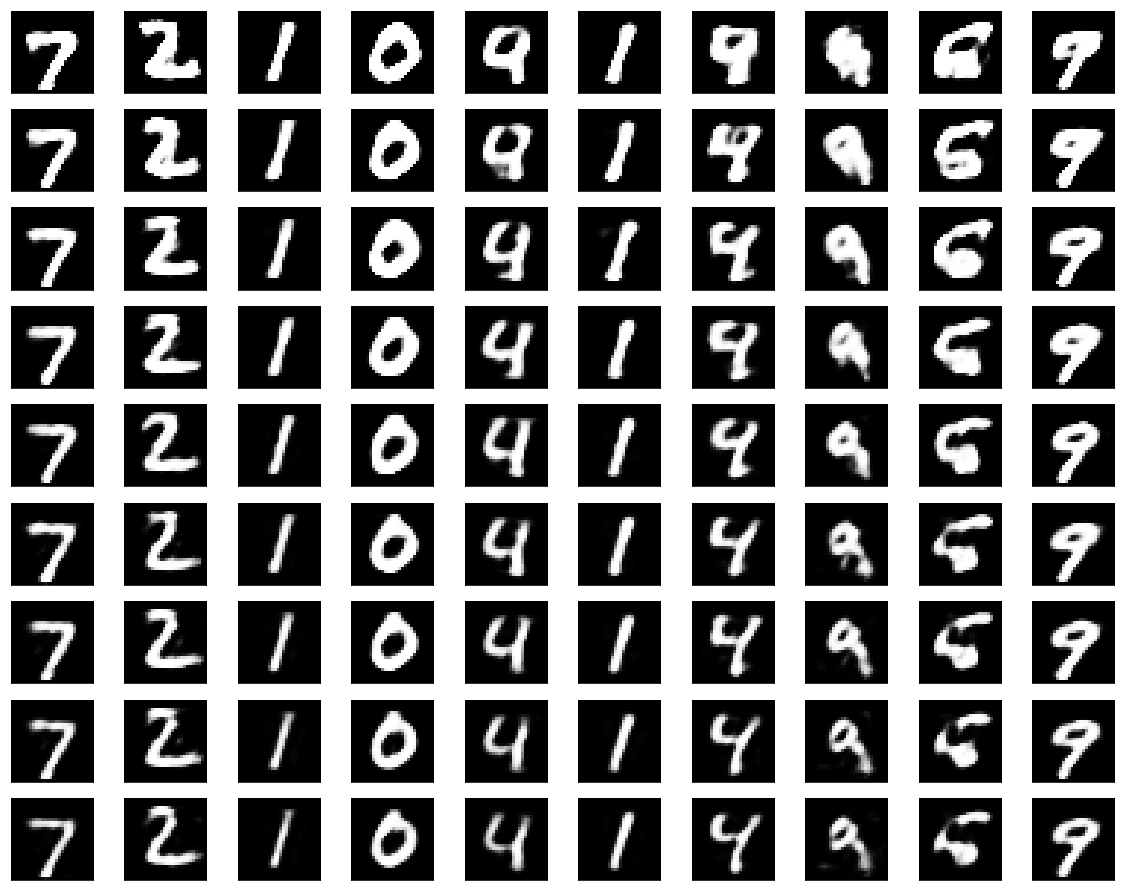

In [30]:
n = 10
plt.figure(figsize=(20, 16))
for p in range(1,10):
    
    autoencoder=load_model('AE/autoencoder_denoise_bern'+str(p)+'.h5')

    decoder=load_model('AE/decoder_denoise_bern'+str(p)+'.h5')
    encoder=load_model('AE/encoder_denoise_bern'+str(p)+'.h5')

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    for i in range(n):  

        ax = plt.subplot(9, n, i+1+n*(p-1))
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
plt.show()

Esta claro que para ciertos digitos, la reconstruccion es insatisfactoria si la corrupcion es muy alta (si p es bajo). Por ejemplo, los cuatros los convierte en nueves, o si el digito esta muy mal escrito, entrega una especie de garabato. Sin embargo, encuentro que resultados son bastante buenos en general.

Se repetira lo anterior por con imagenes corruptas con un filtro de ruido con distribucion normal(n,s) de parametros n=0 y s en (0, 1)

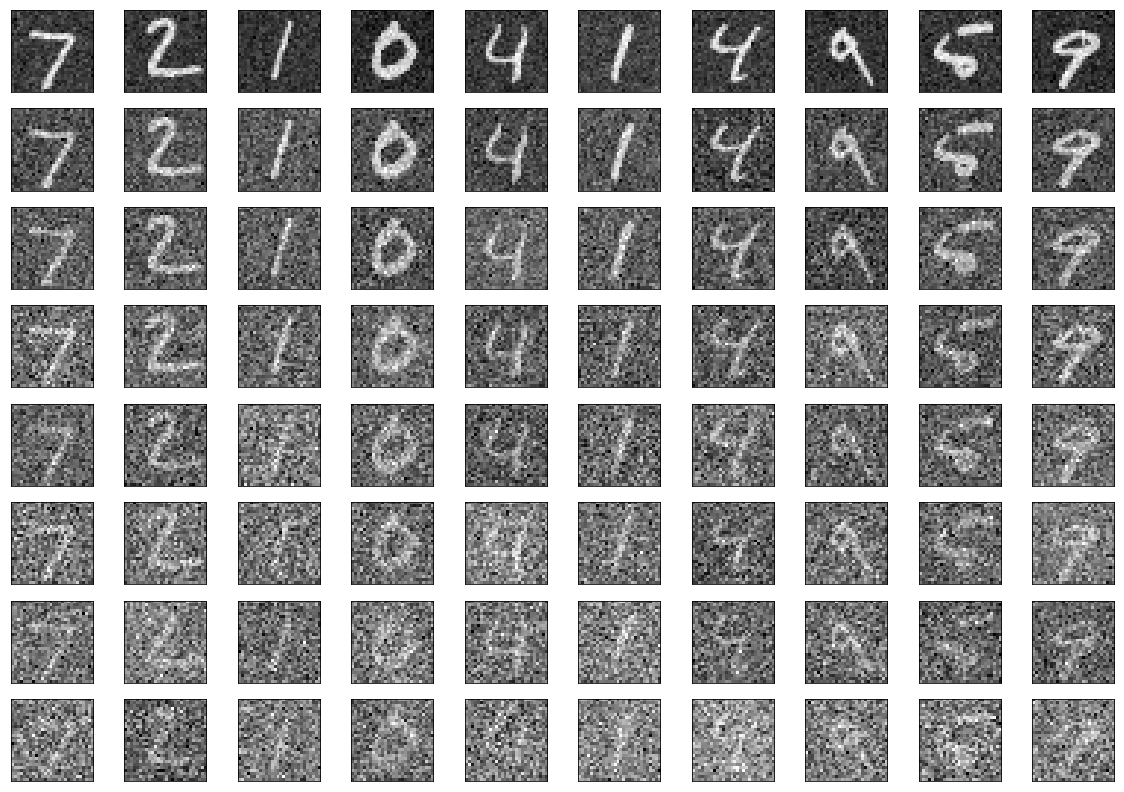

In [37]:
n = 10
plt.figure(figsize=(20, 16))
for p in range(1,9):
    devst = p/10.0
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train+noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val+noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test+noise_mask   

    for i in range(n):  

        ax = plt.subplot(9, n, i+1+n*(p-1))
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
plt.show()

Se crean distintos AE para los distintas desviaciones estandar.

In [40]:


loss=[]
for p in range(1,10) :   
    devst = p/10.0
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train+noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val+noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test+noise_mask   

    input_img = Input(shape=(784,))
    encoded = Dense(32, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(32,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0,momentum=0.9, nesterov=True), loss='binary_crossentropy')
    hist=autoencoder.fit(noisy_x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
    validation_data=(noisy_x_val, x_val))
    autoencoder.save('AE/autoencoder_denoise_norm'+str(p)+'.h5')
    encoder.save('AE/encoder_denoise_norm'+str(p)+'.h5')
    decoder.save('AE/decoder_denoise_norm'+str(p)+'.h5')
    loss.append(hist.history['val_loss'][-1])
print(loss)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 5s - loss: 0.1309 - val_loss: 0.1027
Epoch 2/50
55000/55000 [==============================] - 4s - loss: 0.1007 - val_loss: 0.0995
Epoch 3/50
55000/55000 [==============================] - 4s - loss: 0.0992 - val_loss: 0.0986
Epoch 4/50
55000/55000 [==============================] - 4s - loss: 0.0986 - val_loss: 0.0983
Epoch 5/50
55000/55000 [==============================] - 4s - loss: 0.0984 - val_loss: 0.0982
Epoch 6/50
55000/55000 [==============================] - 4s - loss: 0.0982 - val_loss: 0.0980
Epoch 7/50
55000/55000 [==============================] - 4s - loss: 0.0980 - val_loss: 0.0979
Epoch 8/50
55000/55000 [==============================] - 4s - loss: 0.0979 - val_loss: 0.0977
Epoch 9/50
55000/55000 [==============================] - 4s - loss: 0.0979 - val_loss: 0.0977
Epoch 10/50
55000/55000 [==============================] - 4s - loss: 0.0978 - val_loss: 0.0976


55000/55000 [==============================] - 4s - loss: 0.1016 - val_loss: 0.1018
Epoch 36/50
55000/55000 [==============================] - 4s - loss: 0.1016 - val_loss: 0.1016
Epoch 37/50
55000/55000 [==============================] - 4s - loss: 0.1016 - val_loss: 0.1016
Epoch 38/50
55000/55000 [==============================] - 4s - loss: 0.1016 - val_loss: 0.1015
Epoch 39/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1014
Epoch 40/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1015
Epoch 41/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1014
Epoch 42/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1015
Epoch 43/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1015
Epoch 44/50
55000/55000 [==============================] - 4s - loss: 0.1015 - val_loss: 0.1014
Epoch 45/50
55000/55000 [===========================

55000/55000 [==============================] - 4s - loss: 0.1178 - val_loss: 0.1179
Epoch 20/50
55000/55000 [==============================] - 4s - loss: 0.1177 - val_loss: 0.1178
Epoch 21/50
55000/55000 [==============================] - 4s - loss: 0.1177 - val_loss: 0.1178
Epoch 22/50
55000/55000 [==============================] - 4s - loss: 0.1177 - val_loss: 0.1177
Epoch 23/50
55000/55000 [==============================] - 4s - loss: 0.1176 - val_loss: 0.1176
Epoch 24/50
55000/55000 [==============================] - 4s - loss: 0.1176 - val_loss: 0.1174
Epoch 25/50
55000/55000 [==============================] - 4s - loss: 0.1176 - val_loss: 0.1178
Epoch 26/50
55000/55000 [==============================] - 4s - loss: 0.1175 - val_loss: 0.1173
Epoch 27/50
55000/55000 [==============================] - 4s - loss: 0.1175 - val_loss: 0.1176
Epoch 28/50
55000/55000 [==============================] - 4s - loss: 0.1174 - val_loss: 0.1177
Epoch 29/50
55000/55000 [===========================

55000/55000 [==============================] - 4s - loss: 0.1377 - val_loss: 0.1371
Epoch 4/50
55000/55000 [==============================] - 4s - loss: 0.1371 - val_loss: 0.1366
Epoch 5/50
55000/55000 [==============================] - 4s - loss: 0.1368 - val_loss: 0.1366
Epoch 6/50
55000/55000 [==============================] - 4s - loss: 0.1366 - val_loss: 0.1361
Epoch 7/50
55000/55000 [==============================] - 4s - loss: 0.1364 - val_loss: 0.1359
Epoch 8/50
55000/55000 [==============================] - 4s - loss: 0.1363 - val_loss: 0.1364
Epoch 9/50
55000/55000 [==============================] - 4s - loss: 0.1361 - val_loss: 0.1358
Epoch 10/50
55000/55000 [==============================] - 4s - loss: 0.1360 - val_loss: 0.1360
Epoch 11/50
55000/55000 [==============================] - 4s - loss: 0.1359 - val_loss: 0.1353
Epoch 12/50
55000/55000 [==============================] - 4s - loss: 0.1358 - val_loss: 0.1356
Epoch 13/50
55000/55000 [==============================] -

55000/55000 [==============================] - 4s - loss: 0.1435 - val_loss: 0.1432
Epoch 39/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1430
Epoch 40/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1431
Epoch 41/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1431
Epoch 42/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1431
Epoch 43/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1432
Epoch 44/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1430
Epoch 45/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1430
Epoch 46/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1433
Epoch 47/50
55000/55000 [==============================] - 4s - loss: 0.1434 - val_loss: 0.1431
Epoch 48/50
55000/55000 [===========================

55000/55000 [==============================] - 4s - loss: 0.1588 - val_loss: 0.1594
Epoch 23/50
55000/55000 [==============================] - 4s - loss: 0.1587 - val_loss: 0.1595
Epoch 24/50
55000/55000 [==============================] - 4s - loss: 0.1587 - val_loss: 0.1588
Epoch 25/50
55000/55000 [==============================] - 4s - loss: 0.1587 - val_loss: 0.1592
Epoch 26/50
55000/55000 [==============================] - 4s - loss: 0.1587 - val_loss: 0.1590
Epoch 27/50
55000/55000 [==============================] - 5s - loss: 0.1587 - val_loss: 0.1589
Epoch 28/50
55000/55000 [==============================] - 4s - loss: 0.1586 - val_loss: 0.1592
Epoch 29/50
55000/55000 [==============================] - 4s - loss: 0.1586 - val_loss: 0.1588
Epoch 30/50
55000/55000 [==============================] - 4s - loss: 0.1586 - val_loss: 0.1590
Epoch 31/50
55000/55000 [==============================] - 4s - loss: 0.1586 - val_loss: 0.1587
Epoch 32/50
55000/55000 [===========================

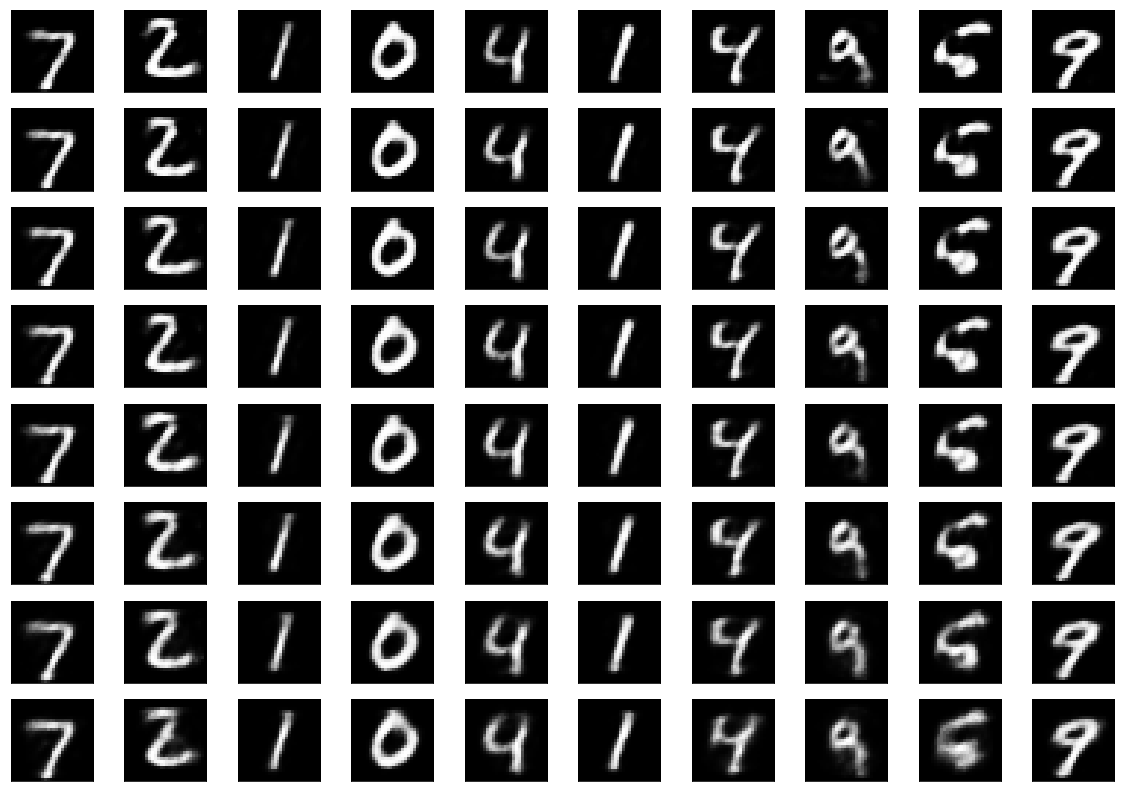

In [41]:
n = 10
plt.figure(figsize=(20, 16))
for p in range(1,9):
    
    autoencoder=load_model('AE/autoencoder_denoise_norm'+str(p)+'.h5')

    decoder=load_model('AE/decoder_denoise_norm'+str(p)+'.h5')
    encoder=load_model('AE/encoder_denoise_norm'+str(p)+'.h5')

    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    for i in range(n):  

        ax = plt.subplot(9, n, i+1+n*(p-1))
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
plt.show()

Se obtuvo el siguiente error de reconstruccion para distintos valores de desviacion estandar.

| s | 0.1   |0.2 |0.3|0.4|0.5|0.6|0.7|0.8|0.9|
|------|------|-|------|--|-|-|-|-|-|
| Error|0.0959| 0.1013| 0.1087| 0.1170| 0.1256| 0.1343| 0.1430| 0.1508| 0.1582|
Cuanta mayor desviacion estandar, mayor error, ya que estan mas sucias las imagenes.
Son mejores los resultados con ruido con distribucion normal a con distribucion de bernoulli, solo para casos con muy alta desviacion estandar se pueden confudir los digitos, sin embargo, son satisfactorios los resultados.

Por ultimo, se pide ocupar algun AC del item a) para reducir la dimension de las imagenes corruptas. Estas se compararan con KNN. Se utilizara p=0.1 y dimension=32

In [8]:
for p in range(1,9):


    noise_level = p/10.0
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask

    encoder=load_model('AE/encoder_denoise_bern'+str(p)+'.h5')
    encoded_test = encoder.predict(x_test)

    clf = KNeighborsClassifier(10)

    clf.fit(encoded_test, Y_test)
    print 'Encoded Classification Accuracy with p=%.1f : %.2f' % (p/10.0,clf.score(encoded_test,Y_test))


Encoded Classification Accuracy with p=0.1 : 0.89
Encoded Classification Accuracy with p=0.2 : 0.90
Encoded Classification Accuracy with p=0.3 : 0.91
Encoded Classification Accuracy with p=0.4 : 0.93
Encoded Classification Accuracy with p=0.5 : 0.94
Encoded Classification Accuracy with p=0.6 : 0.94
Encoded Classification Accuracy with p=0.7 : 0.95
Encoded Classification Accuracy with p=0.8 : 0.95


Al igual que antes, cuanto mas corrupto es peor la representacion, y con esto, el puntaje de KNN. Aun asi, los resultados son apropiados.